In [1]:
%env CUDA_VISIBLE_DEVICES=0

import enum
import strenum
import sys
from typing import Callable, TypeAlias
import torch
import torch.nn as nn
import torch.nn.functional as F
from mishax import ast_patcher
from mishax import safe_greenlet
import numpy as np
import matplotlib.pyplot as plt
import odeformer

import scipy.integrate
import sympy as sp
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

from tqdm import tqdm

sys.path.append("../odeformer/")
sys.path.append("../odeformer/odeformer")
sys.path.append("../odeformer/odeformer/envs")
sys.path.append("../odeformer/odeformer/model")
sys.path.append("../sae")

from sae import SparseAutoencoder

env: CUDA_VISIBLE_DEVICES=0


In [2]:
from odeformer.model import SymbolicTransformerRegressor
from transformer import MultiHeadAttention, TransformerFFN

from odeformer.metrics import r2_score

In [3]:
run_dir = '../sae/sae.encoder.outer.residual3_20250303_001817'
model_path = f'{run_dir}/checkpoints/sae_best_encoder.outer.residual3.pt'

model_full_path = '../sae/sae.encoder.outer.residual3_20250303_001817/checkpoints/sae_best_encoder.outer.residual3.pt'
sae_model = SparseAutoencoder(input_dim=256, latent_dim=2048)
sae_model.load_state_dict(torch.load(model_full_path, map_location='cpu',weights_only=True))
sae_model.eval()

SparseAutoencoder(
  (encoder): Linear(in_features=256, out_features=2048, bias=True)
  (decoder): Linear(in_features=2048, out_features=256, bias=True)
)

In [4]:
class Site(strenum.StrEnum):
    """Instrumentation sites within an ODEFormer forward pass."""
    # Attention sites
    QUERY = enum.auto()
    KEY = enum.auto()
    VALUE = enum.auto()
    ATTN_SCORES = enum.auto()
    ATTN_PROBS = enum.auto()
    ATTN_OUTPUT = enum.auto()
    POST_ATTN_RESIDUAL = enum.auto()
    
    # Layer norm sites
    RESIDUAL = enum.auto()
    
    # Layer norm sites
    PRE_ATTN_LAYERNORM = enum.auto()
    PRE_MLP_LAYERNORM = enum.auto()

    # MLP sites
    MLP_INPUT = enum.auto()
    MLP_HIDDEN = enum.auto()
    MLP_OUTPUT = enum.auto()
    POST_MLP_RESIDUAL = enum.auto()

    # Cross attention (decoder only)
    CROSS_ATTN_SCORES = enum.auto()
    CROSS_ATTN_PROBS = enum.auto()
    CROSS_ATTN_OUTPUT = enum.auto()


def _tag(module: nn.Module, site: Site, value: torch.Tensor, accessing: str = None) -> torch.Tensor:
    """Tags a value at a particular site for instrumentation."""
    try:
        parent = safe_greenlet.getparent()
        if parent is None:
            return value

        ret = value
        
        if accessing=='residual3' and value.shape[2]==256:
            print(f"Using SAE {accessing}")
            mid,_ = sae_model(value)
            ret = mid
        
        return ret if ret is not None else value
    except Exception as e:
        print(f"Error in tag at {site}: {e}")
        return value

def collect_activations_during_fit(model, times, trajectories):
    return collect_activations(lambda: model.fit(times, trajectories))


def install():
    """Installs the patchers to instrument the model."""
    print("\nInstalling patches...")

    PREFIX = f"""from {__name__} import Site, _tag as tag
"""


    patcher = ast_patcher.ModuleASTPatcher(
        odeformer.model.transformer,
        ast_patcher.PatchSettings(
            prefix=PREFIX,
            allow_num_matches_upto={}  # If need to allow multiple matches
        ),
        TransformerModel=[
         #   # LayerNorm and attention
            """            attn = self.attentions[i](tensor, attn_mask, use_cache=use_cache)""",
            """            attn = tag(self, Site.ATTN_OUTPUT, self.attentions[i](tag(self, Site.RESIDUAL,tensor, accessing="residual"+str(i)), attn_mask, use_cache=use_cache), accessing='attention_layer')""",
        ]
    )

    try:
        patcher.install()
        print("\nPatches installed successfully")
    except Exception as e:
        print(f"\nError installing patches: {e}")
        import traceback
        traceback.print_exc()

    return patcher



def collect_activations(model_fn):
    """Collects activations during a model function execution."""
    print("\nStarting activation collection")
    activations = {}

    patcher = install()
    with patcher():
        def run_in_greenlet():
            try:
                print("Starting model execution in greenlet...")
                with torch.cuda.device(0):
                    result = model_fn()
                print("Model execution completed")
                return result
            except Exception as e:
                print(f"Error in greenlet execution: {e}")
                import traceback
                traceback.print_exc()
                raise

        glet = safe_greenlet.SafeGreenlet(run_in_greenlet)
        print(f"Created SafeGreenlet: {glet}")

        with glet:
            try:
                print("Starting greenlet...")
                result = glet.switch()
                print("Initial switch complete")

                while glet:
                    site, value, name = result

                    try:
                        result = glet.switch(value)
                    except StopIteration:
                        break

            except Exception as e:
                print(f"Error in activation collection: {e}")
                import traceback
                traceback.print_exc()
                raise

    return result

In [5]:
# First install patches
install()


Installing patches...

Patches installed successfully


In [6]:
model = SymbolicTransformerRegressor(
    from_pretrained=True)

model_args = {'beam_size':20,
        'beam_temperature':0.1}
model.set_model_args(model_args)

Found pretrained model at odeformer.pt
Loaded pretrained model


In [7]:
with open('../data/solutions/stuart_landau.pkl', 'rb') as f:
    solutions = pickle.load(f)
    print("Loaded Solutions:",len(solutions))

Loaded Solutions: 9


In [8]:
solution = solutions[2]

In [9]:
solution.keys()

dict_keys(['params', 'equations', 'solution', 'time_points'])

In [10]:
np.infty=np.inf

In [11]:
result = collect_activations_during_fit(model, solution['time_points'], solution['solution'])


Starting activation collection

Installing patches...

Patches installed successfully
Created SafeGreenlet: <SafeGreenlet object at 0x7f284e567a80 (otid=0x(nil)) pending>
Starting greenlet...
Starting model execution in greenlet...
Using SAE residual3
Model execution completed
Initial switch complete


In [13]:
model.print()

x_0' = -2.0016 * x_1 + -1.9710 * x_0 * (x_1)**2
x_1' = 2.0016 * x_0 + -2.4534 * (x_1)**3


In [14]:
trajectory=solutions[8]['solution']
times = solutions[8]['time_points']

model.fit(times, trajectory)
pred_traj = model.predict(times, trajectory[0])

model.print()

x_0' = -2.0304 * x_1
x_1' = 1.8972 * x_0 + -0.2297 * (0.0560 + -1.00000000000000 * (x_1)**2)**2


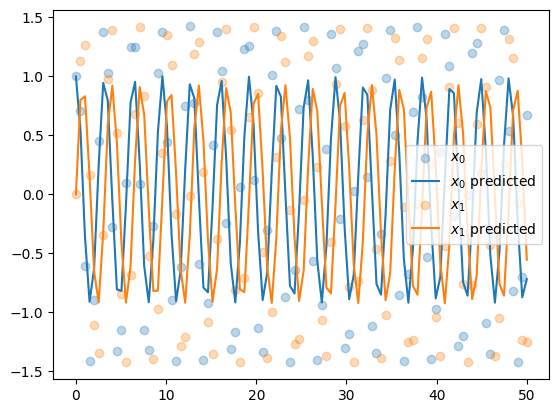

In [15]:
pred_traj = model.predict(times, trajectory[0])
dimension = len(trajectory[0])
for dim in range(dimension):
    plt.scatter(times, trajectory[:, dim], color = f'C{dim}', label=f'$x_{dim}$', marker='o', alpha=.3)
    plt.plot(times, pred_traj[:, dim],  color = f'C{dim}', label=f'$x_{dim}$ predicted')
plt.legend()